In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import fsolve
import torch
import torch.nn as nn
torch.manual_seed(0)
np.random.seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)

import sys
from pathlib import Path

Path("./Paper Figures/").mkdir(parents=True, exist_ok=True)
Path("./Paper Data/").mkdir(parents=True, exist_ok=True)

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
def DEIM(U):
    """
    Compute DEIM interpolation indices given
    U = {u_i}_i matrix with linearly independent columns.
    """
    U = np.copy(U)
    selected_indices = []
    
    for i in range(U.shape[1]):
        idx = np.argmax(np.abs(U[:, i]))
        selected_indices.append(idx)
        U = U - 1/U[idx, i] * U[:, [i]] @ U[[idx], :]
    
    return selected_indices

In [3]:
def weighted_mse_loss(input, target, weight):
    return (weight * (input - target) ** 2).mean()

class Net(nn.Module):
    def __init__(self, in_size, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_size, 50)
        self.fc2 = nn.Linear(50, out_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        return x

def NEIM(ro_sols, f_NEIM, mu, V, max_modes=10, train_loop_iterations=10000):
    """
    Compute NEIM for solution
    independent nonlinearities.
    """
    NUM_PARAMS = f_NEIM.shape[0]
    RO_DIM = ro_sols.shape[1]
    
    #WEIGHTS = np.array([[(abs(i - j) <= 1)/(1+10000*abs(i-j)**2) for j in range(mu.shape[0])] for i in range(mu.shape[0])])
    WEIGHTS = np.ones((mu.shape[0], mu.shape[0]))
    #WEIGHTS = np.array([[np.exp(-100*np.abs(mu[i] - mu[j])) for j in range(mu.shape[0])] for i in range(mu.shape[0])])
    #WEIGHTS = np.array([[(i == j)*1.0 for j in range(mu.shape[0])] for i in range(mu.shape[0])])
    
    selected_indices = []
    trained_networks = []
    
    # NEIM Step 1
    errors = np.array([np.sum(f_NEIM[i, i]**2) for i in range(NUM_PARAMS)])
    idx = np.argmax(errors)
    selected_indices.append(idx)
    print(idx, "Max Error:", errors[idx], "Mean Error:", np.mean(errors))
    
    Network_mu_1 = Net(RO_DIM, RO_DIM)
    mse_weights = torch.tensor(WEIGHTS[idx].reshape(-1, 1))
    optimizer = torch.optim.Adam(Network_mu_1.parameters(), lr=0.001)    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)
    
    x_data = torch.tensor(ro_sols, dtype=torch.double)
    y_data = torch.tensor(np.array([f_NEIM[idx, j]/np.linalg.norm(f_NEIM[idx, j]) for j in range(f_NEIM.shape[1])]))
    
    for epoch in range(train_loop_iterations):
        optimizer.zero_grad()
        output = Network_mu_1(x_data)
        loss = weighted_mse_loss(output, y_data, mse_weights)
        if epoch % 100 == 0:
            print(epoch, loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
    
    Network_mu_1.eval()
    trained_networks.append(Network_mu_1)
    
    thetas = np.zeros((NUM_PARAMS, 1), dtype=np.double)
    for i in range(NUM_PARAMS):
        numerator = 0
        denominator = 0
        for j in range(NUM_PARAMS):
            if i == j:
                net_u_mu = Network_mu_1(x_data[j].view(1, -1)).detach().numpy().reshape(-1)
                numerator += WEIGHTS[i, j] * np.dot(f_NEIM[i, j], net_u_mu)
                denominator += WEIGHTS[i, j] * np.dot(net_u_mu, net_u_mu)

        theta_1_1_i = numerator / denominator
        thetas[i] = theta_1_1_i    
    
    for iteration in range(max_modes-1):
        # current approximation
        approx = lambda sol, param_idx: sum([
            thetas[param_idx][i] * net(torch.tensor(sol).view(1, -1)).T.detach().numpy().reshape(-1)\
            for i, net in enumerate(trained_networks)
        ])
    
        
        # Compute Errors and Choose New Parameter
        errors = np.array([np.sum((f_NEIM[i, i] - approx(ro_sols[i], i))**2) for i in range(NUM_PARAMS)])
        print("Mean Already Selected Error:", np.mean(errors[np.array(selected_indices)]))
        errors[np.array(selected_indices)] = -1
        mu_2_idx = np.argmax(errors)
        selected_indices.append(mu_2_idx)
        print(mu_2_idx, "Max Error:", errors[mu_2_idx], "Mean Error:", np.mean(errors[errors>=0]))
        
        Network_mu_2 = Net(RO_DIM, RO_DIM)
        mse_weights = torch.tensor(WEIGHTS[mu_2_idx].reshape(-1, 1))
        optimizer = torch.optim.Adam(Network_mu_2.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)


        # need to do Gram-Schmidt on this matrix
        previous_y_data = np.copy(y_data)
        y_data = np.copy(f_NEIM[mu_2_idx])
        
        for net in trained_networks:
            # form matrix of evaluations for this network
            previous_net_matrix = np.zeros((NUM_PARAMS, f_NEIM.shape[2]), dtype=np.double)
            for i in range(NUM_PARAMS):
                previous_net_matrix[i] = net(x_data[i].view(1, -1)).detach().numpy().reshape(-1)
                y_data[i] -= np.dot(y_data[i], previous_net_matrix[i]) * previous_net_matrix[i] / np.linalg.norm(previous_net_matrix[i])**2
        
        for j in range(f_NEIM.shape[1]):
             y_data[j] = y_data[j] / np.linalg.norm(y_data[j])
        
        y_data = torch.tensor(y_data, dtype=torch.double)
        
        for epoch in range(train_loop_iterations):
            optimizer.zero_grad()
            output = Network_mu_2(x_data)
            loss = weighted_mse_loss(output, y_data, mse_weights)
            if epoch % 100 == 0:
                print(epoch, loss.item())
            loss.backward()
            optimizer.step()
            scheduler.step(loss)

        Network_mu_2.eval()
        trained_networks.append(Network_mu_2)
        
        # 3c. Find theta_1_2(mu), theta_2_2(mu)
        print("\nFinding theta...")
        num_nets = len(trained_networks)
        thetas = np.zeros((NUM_PARAMS, num_nets), dtype=np.double)
        for i in range(NUM_PARAMS):
            LHS = np.zeros((num_nets, num_nets), dtype=np.double)
            RHS = np.zeros((num_nets, 1), dtype=np.double)

            for j in range(NUM_PARAMS):
                if i == j:
                    nets_u_mu = [net(x_data[j].view(1, -1)).detach().numpy().reshape(-1) for net in trained_networks]
                    for k1 in range(num_nets):
                        RHS[k1] += WEIGHTS[i, j] * np.dot(f_NEIM[i, j], nets_u_mu[k1])
                        for k2 in range(num_nets):
                            LHS[k1, k2] += WEIGHTS[i, j] * np.dot(nets_u_mu[k1], nets_u_mu[k2])

            thetas[i] = np.linalg.solve(LHS, RHS).reshape(-1)
        
    def NEIM_approximation(new_mu, new_sol, num_modes=-1):
        if num_modes == -1:
            num_modes = len(trained_networks)
        
        new_sol = torch.tensor(new_sol)
        thetas_ = interpolate.griddata(mu, thetas, new_mu, method='cubic').reshape(-1)
        if True in np.isnan(thetas_):
            thetas_ = interpolate.griddata(mu, thetas, new_mu, method='nearest').reshape(-1)
        s = 0
        for i, net in enumerate(trained_networks[:num_modes]):
            s += thetas_[i] * net(new_sol.view(1, -1)).view(-1).detach().numpy()
        return s.reshape(-1)
    
    return NEIM_approximation, selected_indices

# Nonlinear parameterized function with spatial points in one dimension
Example from DEIM paper section 3.3.1:

We have a nonlinear parameterized function $s:\Omega\times\mathbb{R}\times\mathcal{P}\to\mathbb{R}$ defined by $$s(x, u;\mu) = (1-\lvert x\rvert)e^{-(1+x)u\mu},$$ where $\Omega = [-1, 1]$ and $\mu\in\mathcal{P} = [1,\pi]$.

Let $\boldsymbol{x} = [x_1,\dots,x_n]^\top\in\mathbb{R}^n$ with $x_i$ equally spaced points in $\Omega$ for $i=1,\dots,n$, with $n=100$. Define $f:\mathcal{P}\to\mathbb{R}^n$ by $$f(\mu) = [s(x_1, u(x_1;\mu);\mu),\dots,s(x_n, u(x_n;\mu);\mu)]^\top\in\mathbb{R}^n$$ for $\mu\in\mathcal{P}$. Here $u(x_i;\mu)$ is the solution of a parameterized PDE with parameter $\mu$ evaluated at $x_i$.

We then use 51 snapshots $f(\mu_j)$ to construct a POD basis $\{u_\ell\}_{\ell=1}^m$, with $\mu_1,\dots,\mu_{51}$ selected as equally spaced points in $[1,\pi]$.

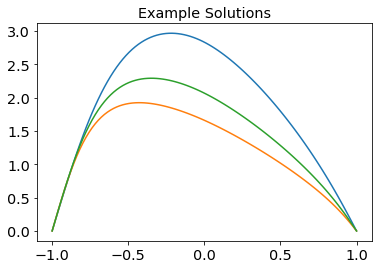

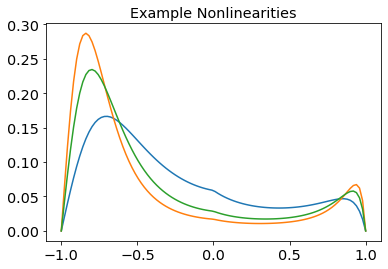

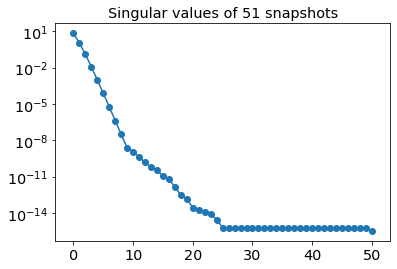

In [4]:
def s(u, x, mu):
    return mu * (1-np.abs(x)) * np.exp(-(1 + x) * u * mu)

def residual(A, u, x, mu):
    u[0] = 0
    u[-1] = 0
    r = (A @ u.reshape(-1, 1) - s(u.reshape(-1, 1), x, mu)).reshape(-1)
    return r

def solution_fn(x, mu):
    # compute full order solutions
    N = x.shape[0]
    A = 2*np.eye(N, dtype=np.double) - np.eye(N, k=1, dtype=np.double) - np.eye(N, k=-1, dtype=np.double)
    A = 30*A
    A[0, :] *= 0
    A[-1, :] *= 0
    A[:, 0] *= 0
    A[:, -1] *= 0
    sols = np.zeros((mu.shape[0], N), dtype=np.double)
    
    for i, m in enumerate(mu): # loop over parameters for nonlinearity
        sol = fsolve(lambda u: residual(A, u, x, m), np.zeros(N)).reshape(-1)
        sol[0] = 0
        sol[-1] = 0
        sols[i] = sol
    return sols

x = np.linspace(-1, 1, 100).reshape(-1, 1)
mu = np.linspace(1, np.pi, 51).reshape(-1,1).T
sols = solution_fn(x, mu.reshape(-1))

plt.plot(x, sols[0])
plt.plot(x, sols[-1])
plt.plot(x, sols[int(sols.shape[0]//2)])
plt.title("Example Solutions")
plt.show()

plt.plot(x, s(sols[0].reshape(-1), x.reshape(-1), mu.reshape(-1)[0]))
plt.plot(x, s(sols[-1].reshape(-1), x.reshape(-1), mu.reshape(-1)[-1]))
plt.plot(x, s(sols[sols.shape[0]//2].reshape(-1), x.reshape(-1), mu.reshape(-1)[sols.shape[0]//2]))
plt.title("Example Nonlinearities")
plt.show()

f = np.array([s(sols[i].reshape(-1, 1), x, mu[0, i]).reshape(-1) for i in range(sols.shape[0])]).T # shape = (space, parameters)

u, sing_vals, vh = np.linalg.svd(f, full_matrices=True)
plt.plot(np.arange(sing_vals.shape[0]), sing_vals)
plt.scatter(np.arange(sing_vals.shape[0]), sing_vals)
plt.yscale("log")
plt.title("Singular values of 51 snapshots")
plt.show()

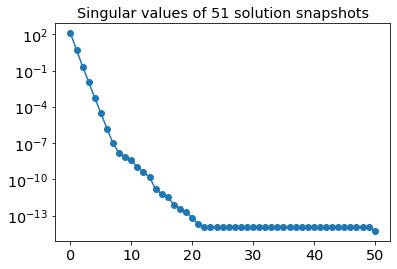

(100, 51)


In [5]:
RO_DIM = 20

# do a POD based on sols
snapshots = np.array([sols[i] for i in range(sols.shape[0])]).T
V, sing_vals, _ = np.linalg.svd(snapshots, full_matrices=False)

plt.scatter(np.arange(sing_vals.shape[0]), sing_vals)
plt.semilogy(np.arange(sing_vals.shape[0]), sing_vals)
plt.title("Singular values of 51 solution snapshots")
plt.savefig(f'./Paper Figures/singular_values_experiment_2.pdf', bbox_inches='tight', dpi=500)
with open(f"./Paper Data/singular_values_experiment_2_x.npy", 'wb') as file_obj:
    np.save(file_obj, np.arange(sing_vals.shape[0]))
with open(f"./Paper Data/singular_values_experiment_2_y.npy", 'wb') as file_obj:
    np.save(file_obj, sing_vals)
plt.show()
print(V.shape)

# get reduced order solutions
ro_sols = np.zeros((sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    ro_sols[i] = (V[:,:RO_DIM].T @ sols[i].reshape(-1, 1)).reshape(-1)

# evaluate nonlinearity at given parameter and solution
f_NEIM = np.zeros((sols.shape[0], sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    for j in range(sols.shape[0]):
        f_NEIM[i, j] = (V[:,:RO_DIM].T @ s(sols[i].reshape(-1, 1), x, mu[0, j]).reshape(-1)).reshape(-1)

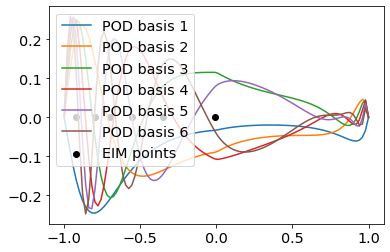

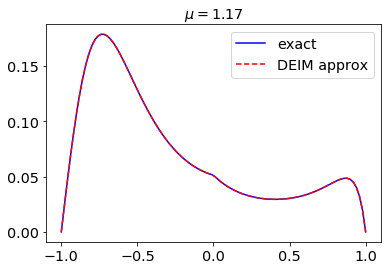

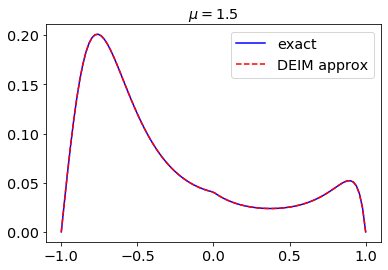

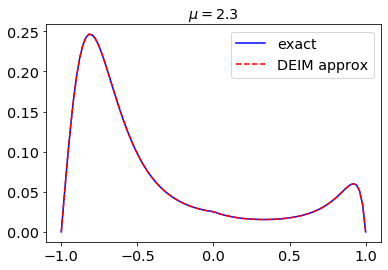

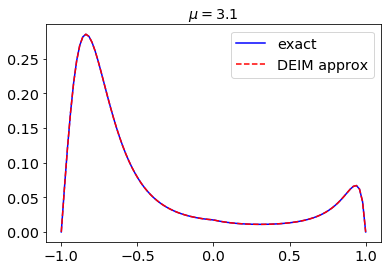

In [6]:
# Get DEIM indices
selected_indices = DEIM(u)

# plot POD basis vectors and first six spatial points
plt.scatter(x[selected_indices[:6]], np.zeros(6), c='black', label="EIM points")
for i in range(6):
    plt.plot(x, u[:, i], label=f"POD basis {i+1}")
plt.legend()
plt.show()

# look at DEIM approximations for these mu values and 10 DEIM modes
test_mu = [1.17, 1.5, 2.3, 3.1]
s_op = np.zeros((f.shape[0], 10)) # selection operator
for i, idx in enumerate(selected_indices[:10]):
    s_op[idx, i] = 1
DEIM_proj = u[:, :10] @ np.linalg.inv(s_op.T @ u[:, :10]) @ s_op.T # DEIM projection
for mu_val in test_mu:
    sol = solution_fn(x, np.array([mu_val]))
    exact = s(sol.reshape(-1, 1), x, mu_val)
    DEIM_approximation = DEIM_proj @ exact
    
    plt.plot(x, exact, label="exact", c='b')
    plt.plot(x, DEIM_approximation, label="DEIM approx", c='r', linestyle="dashed")
    plt.title(f"$\mu = {mu_val}$")
    plt.legend()
    plt.show()

# Compare Errors for DEIM and NEIM

50 Max Error: 1.0470292798018812 Mean Error: 0.8908501006930563
0 0.3518597386023773
100 0.0018885870545644209
200 0.0004380248139831554
300 0.00010749837961882748
400 5.3192970486164143e-05
500 4.028993313300874e-05
600 3.2125147381442365e-05
700 2.5668912116982782e-05
800 2.046466038023511e-05
900 1.6266275708429133e-05
1000 1.2916603674430729e-05
1100 1.0298944301415335e-05
1200 8.30382472875254e-06
1300 6.816910885258976e-06
1400 5.723662962813851e-06
1500 4.920228426934232e-06
1600 4.321712287662769e-06
1700 3.864497922553938e-06
1800 3.5038592900776225e-06
1900 3.209614675603654e-06
2000 2.9618604335402744e-06
2100 2.7476143441607437e-06
2200 2.5773908748634288e-06
2300 2.430635991251749e-06
2400 2.3011427891802837e-06
2500 2.1802358237052506e-06
2600 2.066980818170108e-06
2700 1.9606599583865464e-06
2800 1.860697649532094e-06
2900 1.7666118258593886e-06
3000 1.8943490566050446e-06
3100 1.6211725262737955e-06
3200 1.56200620757937e-06
3300 1.504636095644442e-06
3400 1.44903637481

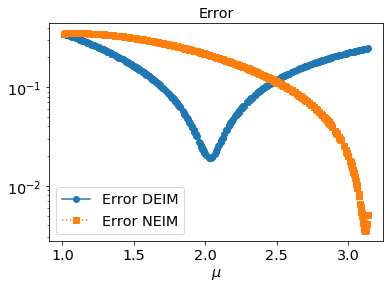

50 Max Error: 1.0470292798018812 Mean Error: 0.8908501006930563
0 0.20712883094066104
100 0.0010715179577062645
200 9.69212331205415e-05
300 5.448750919639461e-05
400 4.172117449637284e-05
500 3.085841045083722e-05
600 2.2641514615183504e-05
700 1.6847445023760887e-05
800 1.2740114525821618e-05
900 9.863616364928276e-06
1000 7.880478680457411e-06
1100 6.5217554719851755e-06
1200 5.576256375514414e-06
1300 4.892019192279812e-06
1400 4.370652725147166e-06
1500 3.950570927032706e-06
1600 3.597623233513041e-06
1700 3.2910870798627348e-06
1800 3.0507044290059535e-06
1900 2.8473129166100853e-06
2000 2.6585453589077267e-06
2100 2.4826837524754395e-06
2200 2.3184130275285452e-06
2300 2.1649009758096767e-06
2400 2.0203978092042766e-06
2500 1.9020425178420422e-06
2600 1.7859560428455453e-06
2700 1.6854724116565733e-06
2800 1.5889990365490303e-06
2900 1.4964451541517215e-06
3000 1.4077870393955839e-06
3100 1.323069960469632e-06
3200 1.2564384224797664e-06
3300 1.198637600600347e-06
3400 1.1432277

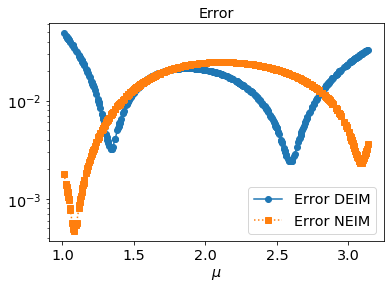

50 Max Error: 1.0470292798018812 Mean Error: 0.8908501006930563
0 0.3460276699796917
100 0.001999482633007057
200 0.00024630246397804674
300 6.106606902077171e-05
400 3.744394091579021e-05
500 2.7547292625324565e-05
600 2.0906237406846988e-05
700 1.6273487767570425e-05
800 1.3061992989415468e-05
900 1.0829832379673686e-05
1000 9.246237495477289e-06
1100 8.080747697181686e-06
1200 7.183646722774534e-06
1300 6.462107199589851e-06
1400 5.863270206366842e-06
1500 5.345534208726495e-06
1600 4.891913589491865e-06
1700 4.486248864428849e-06
1800 4.118943042272342e-06
1900 3.7833486624564046e-06
2000 3.510990701576669e-06
2100 3.270849074421783e-06
2200 3.0483766988075026e-06
2300 2.837536965293567e-06
2400 2.6376194436085104e-06
2500 2.4480762894063786e-06
2600 2.2685226232528922e-06
2700 2.1008577735064466e-06
2800 1.971984214268457e-06
2900 1.859489479780647e-06
3000 1.7509855745018361e-06
3100 1.6466634210434255e-06
3200 1.5467011002474985e-06
3300 1.4512483896542091e-06
3400 1.36042408838

9100 6.768824433207278e-06
9200 6.485664038186392e-06
9300 6.209585442410662e-06
9400 5.964821244162968e-06
9500 5.732705475961838e-06
9600 5.505941667204917e-06
9700 5.284819715760289e-06
9800 5.094466543696786e-06
9900 4.9116032830159436e-06

Finding theta...
[50, 3, 26]


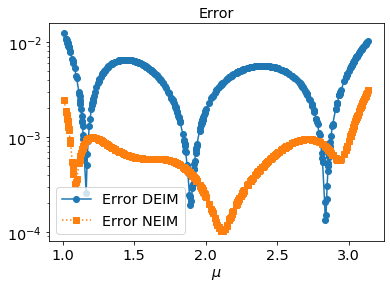

50 Max Error: 1.0470292798018812 Mean Error: 0.8908501006930563
0 0.16215566990283603
100 0.002530624319895973
200 0.00045715714893708454
300 7.782489250976415e-05
400 5.349665557318915e-05
500 4.202470706598151e-05
600 3.355085644032427e-05
700 2.6901962023125636e-05
800 2.1604024552867726e-05
900 1.7423252758715053e-05
1000 1.4198187452825601e-05
1100 1.1755478966249464e-05
1200 9.931450830261508e-06
1300 8.58155743665779e-06
1400 7.576287482668857e-06
1500 6.8508083215190894e-06
1600 6.278773313850791e-06
1700 5.821713327184935e-06
1800 5.427584175878605e-06
1900 5.078138512208402e-06
2000 4.811570546772025e-06
2100 4.51020965279412e-06
2200 4.26308701379243e-06
2300 4.030068221575634e-06
2400 3.8094783442810886e-06
2500 3.600030212293426e-06
2600 3.4274299859161363e-06
2700 3.270807857391798e-06
2800 3.119099231905382e-06
2900 2.9720083192597997e-06
3000 2.8293896495062144e-06
3100 2.7311346979029443e-06
3200 2.5879958353667685e-06
3300 2.4808703364857774e-06
3400 2.37579112684889e

9000 2.750397387784401e-06
9100 2.667448944107428e-06
9200 2.585061393716683e-06
9300 2.5034051295022727e-06
9400 2.422649102207603e-06
9500 2.3429542246128527e-06
9600 2.2779135037624963e-06
9700 2.2210237038071505e-06
9800 2.167181133407652e-06
9900 2.113329151996705e-06

Finding theta...
Mean Already Selected Error: 3.2674338813096297e-06
0 Max Error: 6.439951843961293e-06 Mean Error: 6.989062566447512e-07
0 0.39850158215157777
100 0.0320940799545723
200 0.03088123708673937
300 0.030124342884294778
400 0.029471192333935154
500 0.028932406799381655
600 0.028200942644435463
700 0.026941817439152846
800 0.024786331483466942
900 0.02150701880202374
1000 0.017526984605509253
1100 0.01400472488546146
1200 0.011622517982312975
1300 0.009983345486909613
1400 0.008691257262160156
1500 0.00759777753559007
1600 0.006670109811305027
1700 0.005898391361292673
1800 0.005268654247877587
1900 0.004760807912818307
2000 0.004352461311048344
2100 0.004020481152874662
2200 0.0037453653397666615
2300 0.

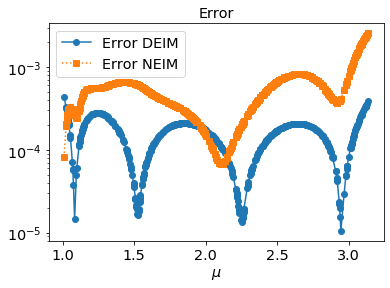

50 Max Error: 1.0470292798018812 Mean Error: 0.8908501006930563
0 0.17009427586004855
100 0.0007030659073022099
200 0.00011784240380263613
300 8.25395426553445e-05
400 6.756127887600824e-05
500 5.4585417979340206e-05
600 4.286809696996133e-05
700 3.2749834769474e-05
800 2.4613523084935877e-05
900 1.8517271822570667e-05
1000 1.4151912788278394e-05
1100 1.1067765854085139e-05
1200 8.862048700446712e-06
1300 7.2465292540785585e-06
1400 6.035335696496054e-06
1500 5.109175152903625e-06
1600 4.386677511684158e-06
1700 3.8099670393408612e-06
1800 3.3839789603641204e-06
1900 3.0447720389390796e-06
2000 2.7621706648708506e-06
2100 2.512293478258118e-06
2200 4.769280020713968e-06
2300 2.1228373747235034e-06
2400 1.972823112486424e-06
2500 1.834095923166996e-06
2600 1.7056942036066497e-06
2700 1.5868112403321541e-06
2800 1.476764704044306e-06
2900 1.3857104134232714e-06
3000 1.3062498322770806e-06
3100 1.2329579596975413e-06
3200 1.1639069088082321e-06
3300 1.0989922440064739e-06
3400 1.038097952

9100 4.530165743429693e-06
9200 4.236901859872801e-06
9300 3.998718270383587e-06
9400 3.8127829779206165e-06
9500 3.632216641202126e-06
9600 3.4555840605884005e-06
9700 3.2835455412350736e-06
9800 3.116723879309872e-06
9900 2.9556862059391314e-06

Finding theta...
Mean Already Selected Error: 2.518189612182442e-06
0 Max Error: 4.778587398490258e-06 Mean Error: 5.738022665801945e-07
0 0.337013243025409
100 0.03196459829315351
200 0.031149550672332882
300 0.03087474890214566
400 0.030644203053793482
500 0.03039550927136984
600 0.030117971789656636
700 0.029734712626423118
800 0.029057921105939088
900 0.027913851917349297
1000 0.026290422281372103
1100 0.02386354507966486
1200 0.020355422306166687
1300 0.016557242973826068
1400 0.013168911603777433
1500 0.010295803292718744
1600 0.007897644262572983
1700 0.006118426243216954
1800 0.004951898212970512
1900 0.004193737589903183
2000 0.003675484696717252
2100 0.0032927088322494413
2200 0.0029831147242596707
2300 0.0027174864518453223
2400 0.

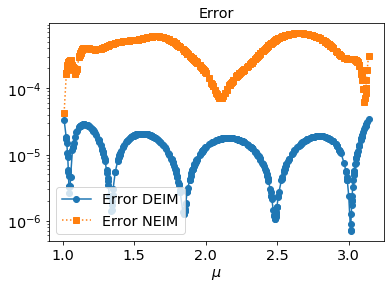

50 Max Error: 1.0470292798018812 Mean Error: 0.8908501006930563
0 0.37334221540618273
100 0.0019684643024578423
200 0.00019945387776328384
300 0.00011006985707292121
400 8.72951388632548e-05
500 6.853854974816782e-05
600 5.244587425320195e-05
700 3.9053057765338825e-05
800 2.9209912398679447e-05
900 2.2024595564961203e-05
1000 1.6736692247692542e-05
1100 1.2858333729703633e-05
1200 1.0032179200492718e-05
1300 7.98098356806556e-06
1400 6.489121151678415e-06
1500 5.392643458674167e-06
1600 4.571973377194249e-06
1700 3.94406044901645e-06
1800 3.4531752199405355e-06
1900 3.06204631829489e-06
2000 2.745017396160868e-06
2100 2.4835941733470766e-06
2200 2.2638261808879336e-06
2300 2.0747646589149255e-06
2400 1.920304860065136e-06
2500 1.7748369291291488e-06
2600 1.6436428896890893e-06
2700 1.51940972211394e-06
2800 1.403993183097316e-06
2900 1.336242843983075e-06
3000 1.2146265634318692e-06
3100 1.134419058559751e-06
3200 1.0603281675700515e-06
3300 9.91872860629135e-07
3400 9.285684882131642

9200 3.1026456148945255e-06
9300 3.0467145423472158e-06
9400 2.99200195901569e-06
9500 3.164170183496458e-06
9600 2.8992958810525915e-06
9700 2.859783261465529e-06
9800 2.8205854262892978e-06
9900 2.781701683224451e-06

Finding theta...
Mean Already Selected Error: 4.403716001657401e-06
0 Max Error: 8.443896446363762e-06 Mean Error: 7.926470853975625e-07
0 0.452654678031469
100 0.03353452335621062
200 0.032555707776464694
300 0.03201856499463243
400 0.03162304379850287
500 0.03127785559908061
600 0.030847764654890315
700 0.02999302659839197
800 0.02790538974592346
900 0.0241082370215988
1000 0.019718530581536962
1100 0.016374970790555325
1200 0.014427408063684638
1300 0.013252290019087917
1400 0.012175955503970132
1500 0.011021437271064425
1600 0.009806561716178603
1700 0.008578123378495606
1800 0.007374518816791121
1900 0.006237343171744579
2000 0.005216040934135913
2100 0.004362204070258728
2200 0.0036914954512814683
2300 0.0031859569454969756
2400 0.0028150209002860867
2500 0.002539

8900 0.0016924993363986738
9000 0.001664166986346656
9100 0.0016361514130757775
9200 0.0016074840269783824
9300 0.001578156860466827
9400 0.001552290089933903
9500 0.0015268576129093142
9600 0.0015007740167848256
9700 0.0014740217066216061
9800 0.0014472044041919376
9900 0.0014205185397230685

Finding theta...
[50, 2, 26, 0, 49, 39]


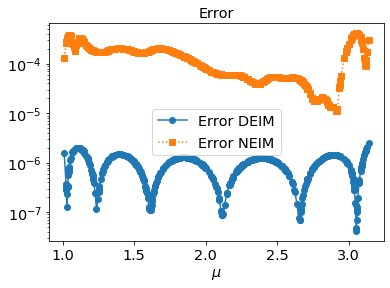

In [7]:
MAX_MODES = 6
NUM_TRAIN_PARAMS = 51
NUM_SPATIAL_POINTS = 100
x = np.linspace(-1, 1, NUM_SPATIAL_POINTS).reshape(-1,1)
mu = np.linspace(1, np.pi, NUM_TRAIN_PARAMS).reshape(-1,1).T
sols = solution_fn(x, mu.reshape(-1))
f = np.array([s(sols[i].reshape(-1, 1), x, mu[0, i]).reshape(-1) for i in range(sols.shape[0])]).T # shape = (space, parameters)

u, sing_vals, vh = np.linalg.svd(f, full_matrices=True)

RO_DIM = 20

# do a POD based on sols
snapshots = np.array([sols[i] for i in range(sols.shape[0])]).T
V, sing_vals, _ = np.linalg.svd(snapshots, full_matrices=False)

# get reduced order solutions
ro_sols = np.zeros((sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    ro_sols[i] = (V[:,:RO_DIM].T @ sols[i].reshape(-1, 1)).reshape(-1)

# evaluate nonlinearity at given parameter and solution
f_NEIM = np.zeros((sols.shape[0], sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    for j in range(sols.shape[0]):
        f_NEIM[i, j] = (V[:,:RO_DIM].T @ s(sols[i].reshape(-1, 1), x, mu[0, j]).reshape(-1)).reshape(-1)

test_mu = np.sort(np.random.uniform(size=500)*(np.pi-1)+1).reshape(-1,1).T
test_sols = solution_fn(x, test_mu.reshape(-1))
f_test = np.array([s(test_sols[i].reshape(-1, 1), x, test_mu[0, i]).reshape(-1) for i in range(test_sols.shape[0])]).T
proj_f_test = np.array([s(V[:, :RO_DIM] @ V[:, :RO_DIM].T @ test_sols[i].reshape(-1, 1), x, test_mu[0, i]).reshape(-1) for i in range(test_sols.shape[0])]).T

DEIM_errors = []
Actual_NEIM_errors = []

for num_modes in range(1, MAX_MODES+1, 1):
    s_op = np.zeros((f.shape[0], num_modes)) # selection operator
    for i, idx in enumerate(DEIM(u)[:num_modes]):
        s_op[idx, i] = 1
    DEIM_proj = u[:, :num_modes] @ np.linalg.inv(s_op.T @ u[:, :num_modes]) @ s_op.T # DEIM projection
    NEIM_approximation, NEIM_selected_indices = NEIM(ro_sols, f_NEIM, mu.reshape(-1), V[:, :RO_DIM], max_modes=num_modes, train_loop_iterations=10000) 
    print(NEIM_selected_indices)
    
    exact = V[:, :RO_DIM].T @ proj_f_test
    DEIM_approximation = V[:, :RO_DIM].T @ DEIM_proj @ proj_f_test
    Actual_NEIM_approximation = np.array([NEIM_approximation(new_mu, (V[:, :RO_DIM].T @ test_sols[i].reshape(-1, 1)).reshape(-1), num_modes) for i, new_mu in enumerate(test_mu.reshape(-1))]).T
    
    avg_error = np.mean([np.linalg.norm(exact[:, i] - DEIM_approximation[:, i]) for i in range(exact.shape[1])])
    DEIM_errors.append(avg_error)
    avg_error = np.mean([np.linalg.norm(exact[:, i] - Actual_NEIM_approximation[:, i]) for i in range(exact.shape[1])])
    Actual_NEIM_errors.append(avg_error)
    
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - DEIM_approximation[:, i]) for i in range(exact.shape[1])], marker='o', label="Error DEIM")
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - Actual_NEIM_approximation[:, i]) for i in range(exact.shape[1])], marker='s', linestyle='dotted', label="Error NEIM")
    plt.yscale("log")
    plt.legend()
    plt.xlabel("$\mu$")
    plt.title("Error")
    plt.savefig(f'./Paper Figures/error_{num_modes}_experiment_2.pdf', bbox_inches='tight', dpi=500)
    with open(f"./Paper Data/error_{num_modes}_experiment_2_x.npy", 'wb') as file_obj:
        np.save(file_obj, test_mu.reshape(-1))
    with open(f"./Paper Data/error_{num_modes}_experiment_2_deim.npy", 'wb') as file_obj:
        np.save(file_obj, [np.linalg.norm(exact[:, i] - DEIM_approximation[:, i]) for i in range(exact.shape[1])])
    with open(f"./Paper Data/error_{num_modes}_experiment_2_neim.npy", 'wb') as file_obj:
        np.save(file_obj, [np.linalg.norm(exact[:, i] - Actual_NEIM_approximation[:, i]) for i in range(exact.shape[1])])
    plt.show()

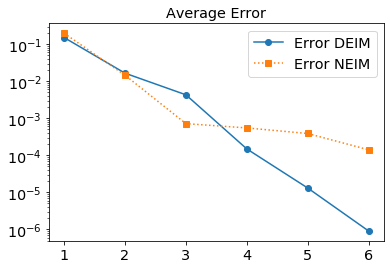

In [8]:
plt.plot(np.arange(1, MAX_MODES+1), DEIM_errors, marker='o', label="Error DEIM")
plt.plot(np.arange(1, MAX_MODES+1), Actual_NEIM_errors, marker='s', linestyle='dotted', label="Error NEIM")
plt.yscale("log")
plt.legend()
plt.title("Average Error")
plt.savefig(f'./Paper Figures/error_by_modes_experiment_2.pdf', bbox_inches='tight', dpi=500)
with open(f"./Paper Data/error_by_modes_experiment_2_x.npy", 'wb') as file_obj:
    np.save(file_obj, np.arange(5, MAX_MODES+1, 5))
with open(f"./Paper Data/error_by_modes_experiment_2_deim.npy", 'wb') as file_obj:
    np.save(file_obj, DEIM_errors)
with open(f"./Paper Data/error_by_modes_experiment_2_neim.npy", 'wb') as file_obj:
    np.save(file_obj, Actual_NEIM_errors)
plt.show()

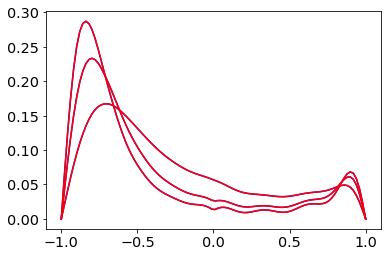

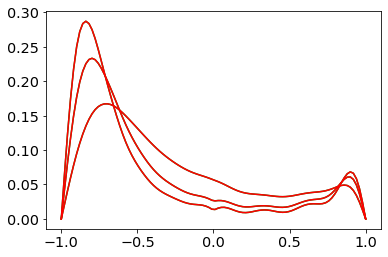

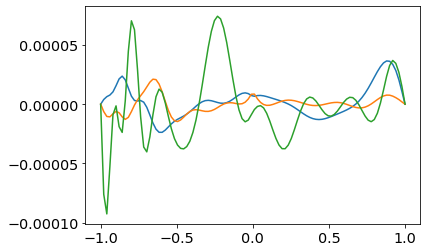

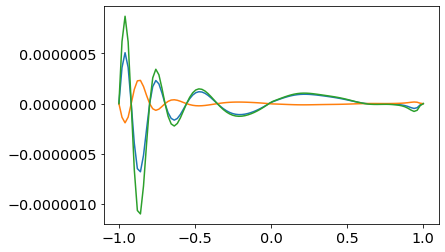

In [9]:
plt.plot(x, V[:,:RO_DIM] @ Actual_NEIM_approximation[:, 0], c='b')
plt.plot(x, V[:,:RO_DIM] @ Actual_NEIM_approximation[:, 250], c='b')
plt.plot(x, V[:,:RO_DIM] @ Actual_NEIM_approximation[:, -1], c='b')

plt.plot(x, V[:,:RO_DIM] @ exact[:, 0], c='r')
plt.plot(x, V[:,:RO_DIM] @ exact[:, 250], c='r')
plt.plot(x, V[:,:RO_DIM] @ exact[:, -1], c='r')
plt.show()

###########################################################

plt.plot(x, V[:,:RO_DIM] @ DEIM_approximation[:, 0], c='g')
plt.plot(x, V[:,:RO_DIM] @ DEIM_approximation[:, 250], c='g')
plt.plot(x, V[:,:RO_DIM] @ DEIM_approximation[:, -1], c='g')

plt.plot(x, V[:,:RO_DIM] @ exact[:, 0], c='r')
plt.plot(x, V[:,:RO_DIM] @ exact[:, 250], c='r')
plt.plot(x, V[:,:RO_DIM] @ exact[:, -1], c='r')
plt.show()

###########################################################

plt.plot(x, V[:,:RO_DIM] @ exact[:, 0] - V[:,:RO_DIM] @ Actual_NEIM_approximation[:, 0])
plt.plot(x, V[:,:RO_DIM] @ exact[:, 250] - V[:,:RO_DIM] @ Actual_NEIM_approximation[:, 250])
plt.plot(x, V[:,:RO_DIM] @ exact[:, -1] - V[:,:RO_DIM] @ Actual_NEIM_approximation[:, -1])
plt.show()

###########################################################

plt.plot(x, V[:,:RO_DIM] @ exact[:, 0] - V[:,:RO_DIM] @ DEIM_approximation[:, 0])
plt.plot(x, V[:,:RO_DIM] @ exact[:, 250] - V[:,:RO_DIM] @ DEIM_approximation[:, 250])
plt.plot(x, V[:,:RO_DIM] @ exact[:, -1] - V[:,:RO_DIM] @ DEIM_approximation[:, -1])
plt.show()